### Load Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Sequential
import os, cv2, joblib, warnings

In [2]:
load_local_models = True

In [3]:
warnings.filterwarnings("ignore")
train_path = 'dataset/Training/'
test_path = 'dataset/Testing/'
classes = {'no_tumor':0, 'positive_tumor':1}
dec = {0:'No Tumor', 1:'Positive Tumor'}
acc_cnn = 0.0
acc_svm = 0.0
acc_rf = 0.0

In [4]:
#########################################################################################################################

In [5]:
### Using CNN

In [6]:
### Prepare the data

In [7]:
X = []
Y = []

for cls in classes:
    pth = os.path.join(train_path, cls)
    for j in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, j), 0)
        img = cv2.resize(img, (200, 200))
        X.append(img)
        Y.append(classes[cls])

X = np.array(X)
Y = np.array(Y)

X = X / 255.0

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=10, test_size=0.20)

xtrain = xtrain.reshape(xtrain.shape[0], 200, 200, 1)
xtest = xtest.reshape(xtest.shape[0], 200, 200, 1)


In [8]:
### Train the Model

In [9]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train Model
cnn_model_path = 'models/cnn_model.h5'

if(load_local_models and os.path.exists(cnn_model_path)):
    model = load_model(cnn_model_path)
else:
    model.fit(xtrain, ytrain, epochs=10, batch_size=32, validation_data=(xtest, ytest))
    model.save(cnn_model_path)

In [11]:
# Predictions
predictions = model.predict(xtest)
predictions = np.round(predictions).flatten()

8/8 [==============================] - 1s 147ms/step


In [12]:
# Accuracy
acc_cnn = accuracy_score(ytest, predictions)
print("Accuracy:", acc_cnn)

Accuracy: 0.9877551020408163


In [13]:
### Test the Data

1/1 [==============================] - 0s 31ms/step


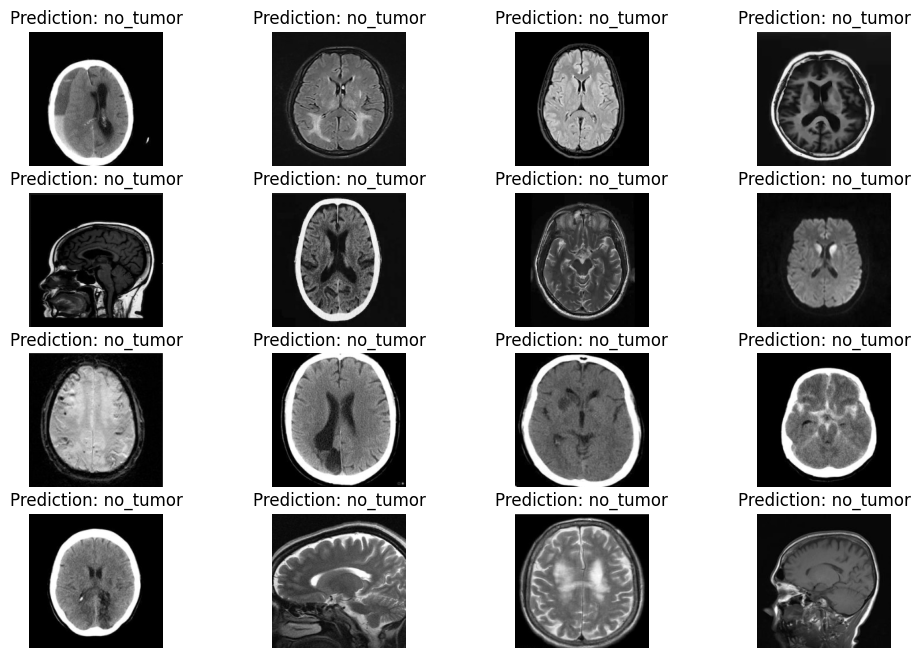

In [14]:
# Test with No Tumor Images
def predict_cnn(model, img_path):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (200, 200))
    img = img.reshape(1, 200, 200, 1) / 255.0
    prediction = model.predict(img)
    return prediction

plt.figure(figsize=(12, 8))
c = 1

path = test_path + 'no_tumor'

for i in os.listdir(path)[:16]:
    img_path = os.path.join(path, i)
    
    plt.subplot(4, 4, c)
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (200, 200))
    
    prediction = predict_cnn(model, img_path)
    class_label = 'positive_tumor' if prediction[0][0] > 0.5 else 'no_tumor'
    
    plt.title(f'Prediction: {class_label}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1

plt.show()

1/1 [==============================] - 0s 30ms/step


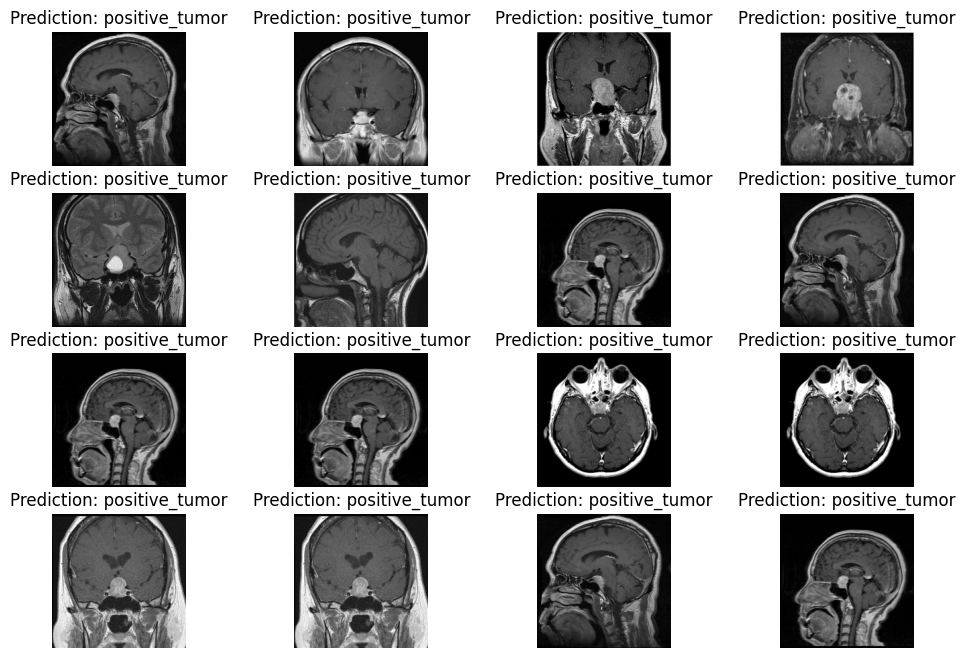

In [15]:
# Test with Tumor Images
plt.figure(figsize=(12, 8))
c = 1

path = test_path + 'positive_tumor'

for i in os.listdir(path)[:16]:
    img_path = os.path.join(path, i)
    
    plt.subplot(4, 4, c)
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (200, 200))
    
    prediction = predict_cnn(model, img_path)
    class_label = 'positive_tumor' if prediction[0][0] > 0.5 else 'no_tumor'
    
    plt.title(f'Prediction: {class_label}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1

plt.show()

In [16]:
#########################################################################################################################

In [17]:
### Using SVM

In [18]:
### Prepare the data

In [19]:
X = []
Y = []
for cls in classes:
    pth = os.path.join(train_path, cls)
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (200,200))
        X.append(img)
        Y.append(classes[cls])


X = np.array(X)
Y = np.array(Y)

X_updated = X.reshape(len(X), -1)

print(X.shape)
X_updated = X.reshape(len(X), -1)
print(X_updated.shape)

(1222, 200, 200)
(1222, 40000)


### Visualize data

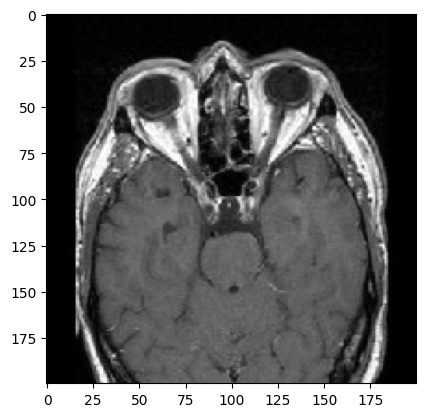

In [20]:
plt.imshow(X[0], cmap='gray')

In [21]:
# Prepare Data
xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10,
                                               test_size=.20)
print(xtrain.shape, xtest.shape)

# Feature Scaling
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain/255
xtest = xtest/255
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())

(977, 40000) (245, 40000)
255 0
255 0
1.0 0.0
1.0 0.0


In [22]:
### Train Model

In [23]:
sv = SVC()

svm_model_path = "models/svm_model.joblib"

if(load_local_models and os.path.exists(svm_model_path)):
    sv = joblib.load(svm_model_path)
else:
    sv.fit(xtrain, ytrain)
    joblib.dump(model, svm_model_path)

In [24]:
acc_svm = sv.score(xtest, ytest)
# print("Training Score:", sv.score(xtrain, ytrain))
print("Testing Score:", acc_svm)

Testing Score: 0.963265306122449


In [25]:
### Evaluation

In [26]:
pred = sv.predict(xtest)
misclassified=np.where(ytest!=pred)
misclassified

(array([ 36,  51,  68, 120, 212, 214, 220, 227, 239], dtype=int64),)

In [27]:
print("Total Misclassified Samples: ",len(misclassified[0]))
print(pred[36],ytest[36])

Total Misclassified Samples:  9
0 1


In [28]:
### Test the Model

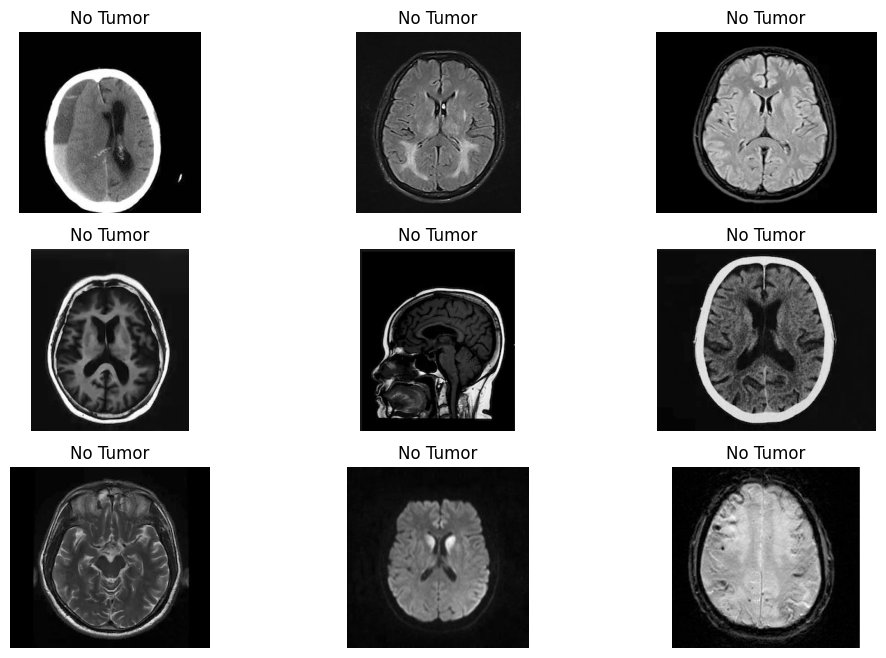

In [29]:
# Test with No Tumor Images

plt.figure(figsize=(12,8))
c=1
path = test_path + 'no_tumor/'

for i in os.listdir(path)[:9]:
    plt.subplot(3,3,c)
    
    img = cv2.imread(path+i,0)
    img1 = cv2.resize(img, (200,200))
    img1 = img1.reshape(1,-1)/255
    p = sv.predict(img1)
    plt.title(dec[p[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c+=1
    

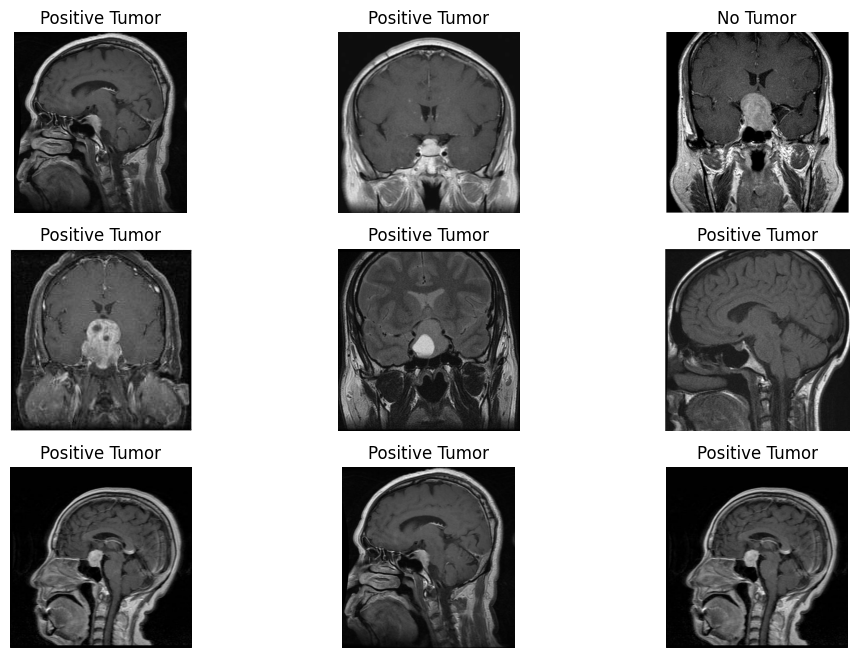

In [30]:
# Test with Tumor Images

plt.figure(figsize=(12,8))
c=1
path = test_path + 'positive_tumor/'

for i in os.listdir(path)[:9]:
    plt.subplot(3,3,c)
    
    img = cv2.imread(path+i,0)
    img1 = cv2.resize(img, (200,200))
    img1 = img1.reshape(1,-1)/255
    p = sv.predict(img1)
    plt.title(dec[p[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c+=1

In [31]:
#########################################################################################################################

In [32]:
### Using Random Forest Classifier

In [33]:
### Prepare the Data

[0 1]
1    827
0    395
Name: count, dtype: int64


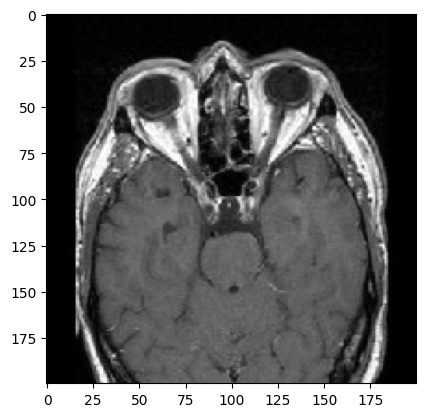

In [34]:
X = []
Y = []
for cls in classes:
    pth = train_path + cls
    for j in os.listdir(pth):
        img = cv2.imread(pth + '/' + j, 0)
        img = cv2.resize(img, (200, 200))
        X.append(img)
        Y.append(classes[cls])

X = np.array(X)
Y = np.array(Y)

X_updated = X.reshape(len(X), -1)

print(np.unique(Y))
print(pd.Series(Y).value_counts())
plt.imshow(X[0], cmap='gray')

In [35]:
# Prepare the data
X_updated = X.reshape(len(X), -1)
X_updated.shape

xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10,
                                               test_size=.20)
xtrain.shape, xtest.shape

((977, 40000), (245, 40000))

In [36]:
# Feature Scaling
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain / 255
xtest = xtest / 255
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())

255 0
255 0
1.0 0.0
1.0 0.0


In [37]:
### Train the Model

In [38]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model_path = "models/rf_model.joblib"
if(load_local_models and os.path.exists(rf_model_path)):
    rf = joblib.load(rf_model_path)
else:
    rf.fit(xtrain, ytrain)
    joblib.dump(rf, rf_model_path)

In [39]:
# Predictions
y_pred_rf = rf.predict(xtest)

In [40]:
# Accuracy
acc_rf = accuracy_score(ytest, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf}")

Random Forest Accuracy: 0.9714285714285714


In [41]:
### Test the Model

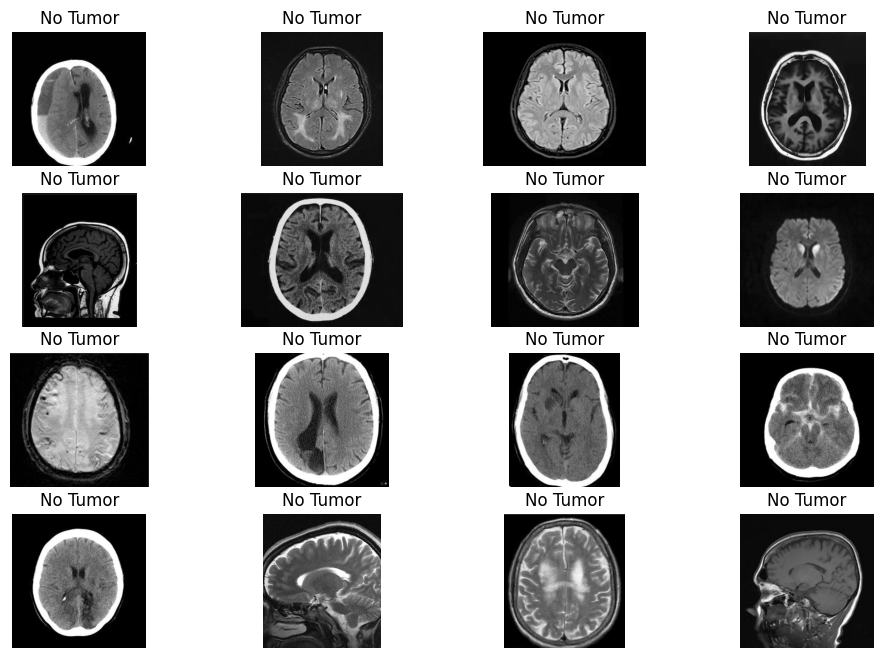

In [42]:
# Test with No Tumor Images 

plt.figure(figsize=(12, 8))
c = 1

path = test_path + 'no_tumor/'

for i in os.listdir('dataset/Testing/no_tumor/')[:16]:
    plt.subplot(4, 4, c)
    img = cv2.imread('dataset/Testing/no_tumor/' + i, 0)
    img1 = cv2.resize(img, (200, 200))
    img1 = img1.reshape(1, -1) / 255
    prediction = rf.predict(img1)
    plt.title(dec[prediction[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1

plt.show()


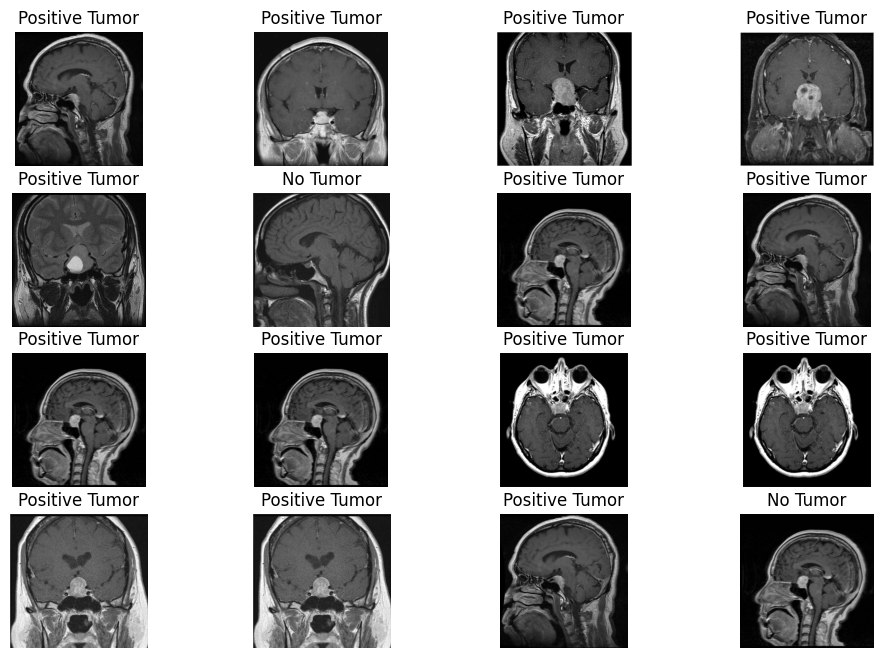

In [43]:
# Test with Tumor Images 

plt.figure(figsize=(12, 8))
c = 1

path = test_path + 'positive_tumor/'

for i in os.listdir(path)[:16]:
    plt.subplot(4, 4, c)
    img = cv2.imread(path + i, 0)
    img1 = cv2.resize(img, (200, 200))
    img1 = img1.reshape(1, -1) / 255
    prediction = rf.predict(img1)
    plt.title(dec[prediction[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1

plt.show()


In [44]:
print(f"\tAccuracy using CNN Model:\t {acc_cnn} \n\
        Accuracy using SVM Model:\t {acc_svm} \n\
        Accuracy using Random Forest:\t {acc_rf} \n\
")

	Accuracy using CNN Model:	 0.9877551020408163 
        Accuracy using SVM Model:	 0.963265306122449 
        Accuracy using Random Forest:	 0.9714285714285714 

